In [94]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import functools
import seaborn as sn

In [95]:
df_tweets = pd.read_csv('data/tweets_no_dupl.csv', sep='#')
df_users = pd.read_csv('data/users_clean.csv', sep='#')

# Tweets csv cleaning

## id
In the id column there are only two missing values. Since the column is not meaningful for the analysis phase, the column is dropped.

## user_id
In the user_id column there are a lot of missing values, wrong values (non-numerical ids) and 210778 user ids do not have any correspondence with users file. Nevertheless, these records have been kept because the other columns could be useful for future analyses.

## retweet_count


In [96]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              11712346 non-null  object
 1   user_id         11495314 non-null  object
 2   retweet_count   11275326 non-null  object
 3   reply_count     11064671 non-null  object
 4   favorite_count  11064981 non-null  object
 5   num_hashtags    10655073 non-null  object
 6   num_urls        11063920 non-null  object
 7   num_mentions    10858432 non-null  object
 8   created_at      11712348 non-null  object
 9   text            11182415 non-null  object
dtypes: object(10)
memory usage: 893.6+ MB


In [97]:
df_tweets.drop(columns=['id'], inplace=True)

Select records which have both user_id and text values which are null

In [98]:
df_tweets[np.logical_and(df_tweets['user_id'].isnull(), df_tweets['text'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56118 entries, 42 to 11712030
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         0 non-null      object
 1   retweet_count   51567 non-null  object
 2   reply_count     25737 non-null  object
 3   favorite_count  50960 non-null  object
 4   num_hashtags    392 non-null    object
 5   num_urls        26107 non-null  object
 6   num_mentions    466 non-null    object
 7   created_at      56118 non-null  object
 8   text            0 non-null      object
dtypes: object(9)
memory usage: 4.3+ MB


Merge users table with tweets table by user_id

In [99]:
df_users.id = df_users.id.astype(str)
merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')


In [100]:
df_tweets.shape

(11712348, 9)

In [101]:
merged.shape

(11712348, 16)

Number of `user_id` that have no correspondance in users file.

In [102]:
len(merged[merged['id'].isnull()].user_id.unique())

210778

Cast column values to float (there are number to big for int) and set to -1.0 when there is a value which is not a number or an uncastable value (e.g. string)

In [103]:
def to_float(x):
    try:
        x=float(x)
        if(np.isnan(x)):
            return float(-1)
        else:
            return x
    except:
        return float(-1)

# Correlation tests

In [104]:
def eval_correlation(df_corr, method='pearson'):
    correlation_matrix = df_corr.corr(method=method)
    sn.heatmap(correlation_matrix, annot=True)
    plt.show()

In [105]:
df_tweets['retweet_count_conv'] = df_tweets.retweet_count.apply(to_float)

In [106]:
df_tweets['reply_count_conv'] = df_tweets.reply_count.apply(to_float)

In [107]:
df_tweets['favorite_count_conv'] = df_tweets.favorite_count.apply(to_float)

We have noticed a lot of huge values in the `retweet_count_conv` **(RCC)** column. By analysing statistics of real tweets on the web, we have decide to perform further analysis on records having a RCC value lower than 1e7 (https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets)

In [108]:
threshold = 1e7
df_correlation = pd.DataFrame()
df_correlation = df_tweets[functools.reduce(np.logical_and,
                                (np.logical_and(df_tweets['retweet_count_conv'] != -1, df_tweets['retweet_count_conv'] < threshold),
                                np.logical_and(df_tweets['reply_count_conv'] != -1, df_tweets['reply_count_conv'] < threshold),
                                np.logical_and(df_tweets['favorite_count_conv'] != -1, df_tweets['favorite_count_conv'] < threshold)))
                    ][['retweet_count_conv', 'reply_count_conv', 'favorite_count_conv']]
df_correlation.head()

,retweet_count_conv,reply_count_conv,favorite_count_conv
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,114.0,0.0,0.0


In [109]:
df_correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10297438 entries, 0 to 11712347
Data columns (total 3 columns):
 #   Column               Dtype  
---  ------               -----  
 0   retweet_count_conv   float64
 1   reply_count_conv     float64
 2   favorite_count_conv  float64
dtypes: float64(3)
memory usage: 314.3 MB


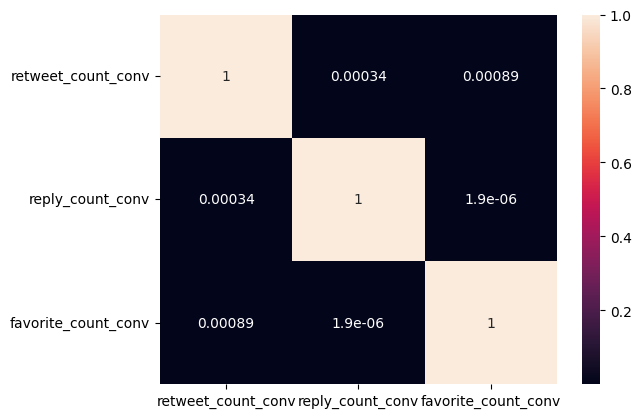

In [110]:
eval_correlation(df_correlation)

C:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4868: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


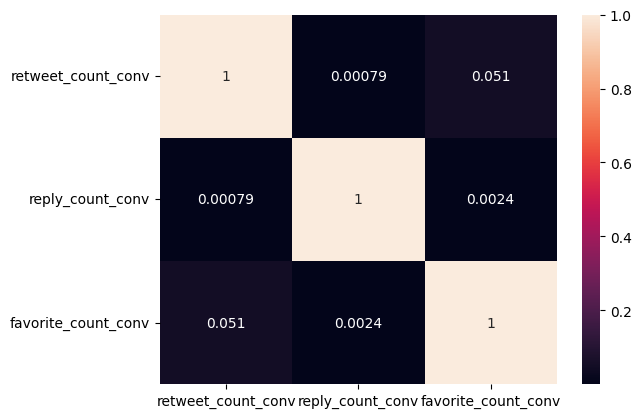

In [111]:
eval_correlation(df_correlation, 'kendall')

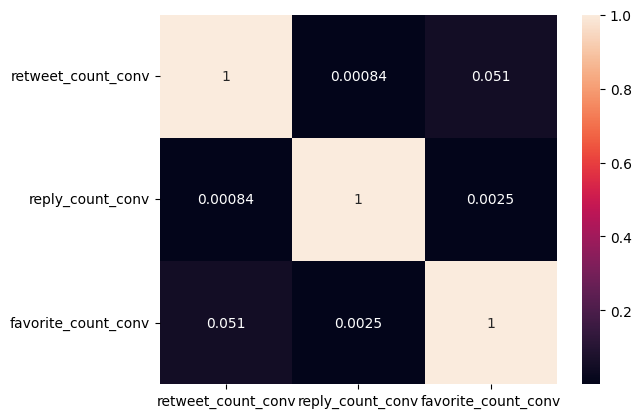

In [112]:
eval_correlation(df_correlation, 'spearman')

## Clean retweet_counts column

Plot a histogram w.r.t. a single attribute passed as parameter.

In [113]:
def plot_hist_log(dataframe, attribute_name):
    attr_log = pd.DataFrame()
    attr_log[attribute_name + '_log'] = np.log(dataframe[attribute_name].values)
    attr_log[attribute_name + '_log'] = attr_log[attribute_name + '_log'].replace(-np.inf, 0)

    n_bins = math.ceil(np.log2(len(attr_log[attribute_name + '_log'])) + 1) #Sturges' rule
    attr_log.hist(attribute_name + '_log', bins = n_bins, log=True)

In [114]:
def fix_missing_values(df, col):
    #Extract statistical indicators from the indicated column
    mean = np.mean(df[col].values)
    median = np.median(df[col].values)
    print("mean: " + str(mean))
    print("median: " + str(median))

    #Plot the distribution of the indicated column
    plt.boxplot(df_tweets[df[col] != -1.0][col],showmeans=True)
    plt.yscale('log')
    plt.show()

    #Substitute all the -1.0 values (missing values) with the median
    df[col+'_rep'] = df[col].replace({-1.0: median})

    return df

In [115]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              object 
 1   retweet_count        object 
 2   reply_count          object 
 3   favorite_count       object 
 4   num_hashtags         object 
 5   num_urls             object 
 6   num_mentions         object 
 7   created_at           object 
 8   text                 object 
 9   retweet_count_conv   float64
 10  reply_count_conv     float64
 11  favorite_count_conv  float64
dtypes: float64(3), object(9)
memory usage: 1.0+ GB


As it is possible to see the distribution is positively skewed. Considering the statistical indicators, it is clear that the mean is too much influenced by outliers so the median has been taken in account.

mean: inf
median: 0.0


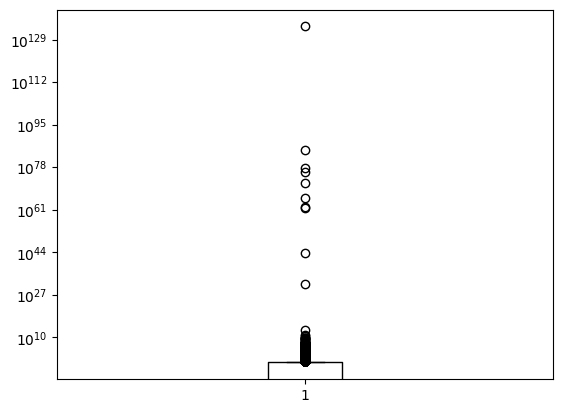

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text,retweet_count_conv,reply_count_conv,favorite_count_conv,retweet_count_conv_rep
0,327746321,0,0,0,0,0,0,2019-09-11 14:53:55,"If man is a little lower than angels, then ang...",0.0,0.0,0.0,0.0
1,333722906,1,0,0,0,0,1,2020-04-01 20:27:04,"""@BestWSHHVids: how do you say these words wit...",1.0,0.0,0.0,1.0
2,2379755827,0,0,0,0,0,1,2019-05-02 13:34:31,@LOLatComedy awsome,0.0,0.0,0.0,0.0
3,466226882,0,0,0,0,0,0,2019-11-04 07:17:37,Stephen Hawkins: i buchi neri non esistono se ...,0.0,0.0,0.0,0.0
4,1355537995,114,0,0,1,0,1,2020-03-11 16:45:31,RT @tibbs_montris: So ready for Wednesday!,114.0,0.0,0.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11712343,220933018,0,0,0,0,0,0,2018-05-04 05:29:33,ESTA MANANA AUN ESTA MUY FRIO ! MIREN ESTO ! ...,0.0,0.0,0.0,0.0
11712344,587491046,0,0,0,0,0,1,2020-04-17 02:51:53,"@warriors Congrats, maybe I'll be able to get ...",0.0,0.0,0.0,0.0
11712345,91781300,0,NaN,l25suv5,NaN,0.0,NaN,2016-07-10 22:43:09,NaN,0.0,-1.0,-1.0,0.0
11712346,127895572,0,0,1,1,0,0,2019-03-07 19:56:55,Shooting crew of porn movies. #TheWorstJobToHave,0.0,0.0,1.0,0.0


In [116]:
fix_missing_values(df_tweets, 'retweet_count_conv')

In [117]:
df_tweets.drop(columns = ['retweet_count_conv', 'retweet_count'], inplace=True)

Now we have `retweet_count_replaced` with all numeric values. We have many values that seems to be "noise" but before replacing them we want to explore the correlation with other attributes related to the tweet popularity which are  `reply_count` and `favourite_count`. So this task is postponed. Instead for the missing values (-1) we have checked if the same user has other tweets in the dataset to extract statistics from them. If there are not other tweets or there are only tweets with missing values the median is set as default.

# Clean reply_count column

mean: inf
median: 0.0


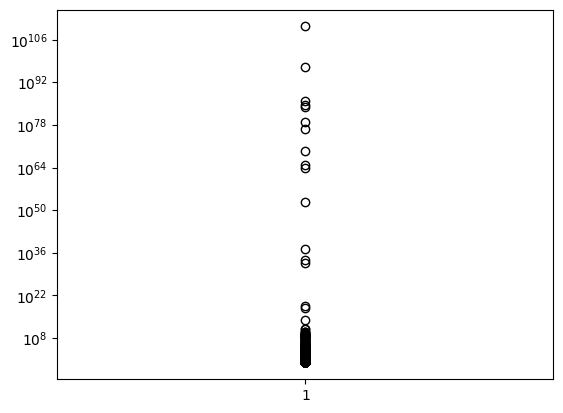

,user_id,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text,reply_count_conv,favorite_count_conv,retweet_count_conv_rep,reply_count_conv_rep
0,327746321,0,0,0,0,0,2019-09-11 14:53:55,"If man is a little lower than angels, then ang...",0.0,0.0,0.0,0.0
1,333722906,0,0,0,0,1,2020-04-01 20:27:04,"""@BestWSHHVids: how do you say these words wit...",0.0,0.0,1.0,0.0
2,2379755827,0,0,0,0,1,2019-05-02 13:34:31,@LOLatComedy awsome,0.0,0.0,0.0,0.0
3,466226882,0,0,0,0,0,2019-11-04 07:17:37,Stephen Hawkins: i buchi neri non esistono se ...,0.0,0.0,0.0,0.0
4,1355537995,0,0,1,0,1,2020-03-11 16:45:31,RT @tibbs_montris: So ready for Wednesday!,0.0,0.0,114.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11712343,220933018,0,0,0,0,0,2018-05-04 05:29:33,ESTA MANANA AUN ESTA MUY FRIO ! MIREN ESTO ! ...,0.0,0.0,0.0,0.0
11712344,587491046,0,0,0,0,1,2020-04-17 02:51:53,"@warriors Congrats, maybe I'll be able to get ...",0.0,0.0,0.0,0.0
11712345,91781300,NaN,l25suv5,NaN,0.0,NaN,2016-07-10 22:43:09,NaN,-1.0,-1.0,0.0,0.0
11712346,127895572,0,1,1,0,0,2019-03-07 19:56:55,Shooting crew of porn movies. #TheWorstJobToHave,0.0,1.0,0.0,0.0


In [118]:
fix_missing_values(df_tweets, 'reply_count_conv')

In [119]:
df_tweets.drop(columns = ['reply_count_conv', 'reply_count'], inplace=True)

# Clean favourite_counts column

In [120]:
fix_missing_values(df_tweets, 'favourite_count_conv')

KeyError: 'favourite_count_conv'

In [ ]:
df_tweets.drop(columns = ['favourite_count_conv', 'favourite_count'], inplace=True)

Check correlation between `retweet_counts`, `replay_counts` and `favourite_counts`

In [ ]:
df_tweets[df_tweets['retweet_count_replaced'] < 1e6].boxplot('retweet_count_replaced', showmeans=True)

In [ ]:
droppe = df_tweets[np.logical_and(df_tweets['retweet_count_conv'] != -1.0, df_tweets['retweet_count_conv'] < threshold)]

In [ ]:
plt.boxplot(droppe.retweet_count_conv,showmeans=True)
plt.yscale('log')
plt.show()

The boxplot is not informative, so we investigate this field by means of an histogram.

In [ ]:
plot_hist_log(droppe, 'retweet_count_conv')

In [ ]:
merged = df_tweets[df_tweets['retweet_count_replaced'] > 1e10].merge(df_users, left_on='user_id', right_on='id', how='left')
merged[['user_id', 'retweet_count_replaced', 'reply_count', 'favorite_count', 'bot', 'created_at_x', 'created_at_y', 'text', 'statuses_count']]

In [ ]:
plot_hist_log(df_tweets[df_tweets['reply_count_conv'] < 1e10], 'reply_count_conv')